# v19 Inference Test - XLM-RoBERTa-large with High-Quality Data

This notebook tests the v19 model trained with high-quality MUSE data (excluding wikidata).

## v19 Key Features:
- **Dataset**: v19_high_quality (~18K pairs, MUSE only, no wikidata)
- **Model**: xlm-roberta-large
- **Learning rate**: 2e-6 (same as v17)
- **Epochs**: 10
- **Loss weights**: self=2.0, target=5.0, margin=3.0, negative=0.5, sparsity=0.005

In [1]:
import sys
from pathlib import Path

# Find project root
def find_project_root():
    """Find project root by looking for markers like pyproject.toml or src/"""
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / "pyproject.toml").exists() or (parent / "src").exists():
            return parent
    return Path.cwd().parent.parent

PROJECT_ROOT = find_project_root()
sys.path.insert(0, str(PROJECT_ROOT))

import torch
import json
from transformers import AutoTokenizer
from src.model.splade_model import create_splade_model

print(f"Project root: {PROJECT_ROOT}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train
PyTorch version: 2.10.0.dev20251109+cu130
CUDA available: True


## 1. Load v19 Model

In [2]:
# Load v19 model
model_path = PROJECT_ROOT / "outputs" / "v19_xlm_large" / "best_model.pt"
print(f"Loading model from: {model_path}")
print(f"Model exists: {model_path.exists()}")

checkpoint = torch.load(model_path, map_location="cpu", weights_only=False)
config = checkpoint["config"]

print(f"\nModel Configuration:")
for key, value in config.items():
    if not isinstance(value, Path):
        print(f"  {key}: {value}")

print(f"\nBest Model Info:")
print(f"  Epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"  Korean Rate: {checkpoint.get('ko_rate', 'N/A'):.1f}%")
print(f"  English Rate: {checkpoint.get('en_rate', 'N/A'):.1f}%")
print(f"  Combined Score: {checkpoint.get('combined_score', 'N/A'):.1f}")

Loading model from: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v19_xlm_large/best_model.pt
Model exists: True

Model Configuration:
  model_name: xlm-roberta-large
  max_length: 64
  data_path: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v19_high_quality/term_mappings.jsonl
  batch_size: 64
  gradient_accumulation_steps: 2
  num_epochs: 15
  learning_rate: 3e-06
  warmup_ratio: 0.1
  max_grad_norm: 1.0
  lambda_self: 2.0
  lambda_target: 5.0
  lambda_margin: 3.0
  lambda_negative: 1.0
  lambda_sparsity: 0.01
  target_margin: 2.0
  use_fp16: True
  output_dir: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v19_xlm_large

Best Model Info:
  Epoch: 1
  Korean Rate: 62.8%
  English Rate: 0.0%
  Combined Score: 62.8


In [3]:
# Load tokenizer
model_name = config.get("model_name", "xlm-roberta-large")
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f"Tokenizer: {model_name}")
print(f"Vocab size: {tokenizer.vocab_size:,}")

# Create model
model = create_splade_model(
    model_name=model_name,
    use_expansion=True,
    expansion_mode="mlm",
)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Device: {device}")

Tokenizer: xlm-roberta-large
Vocab size: 250,002


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/west/Documents/cursor-workspace/opensearch-neural-pre-train/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


Device: cuda


## 2. Define Inference Helper Functions

In [4]:
def encode_term(term: str, top_k: int = 20) -> dict:
    """Encode a term and return top-k tokens with weights."""
    inputs = tokenizer(
        term, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=64
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        weights, _ = model(inputs["input_ids"], inputs["attention_mask"])
    
    # Get top-k tokens
    top_indices = weights[0].topk(top_k).indices.tolist()
    top_values = weights[0].topk(top_k).values.tolist()
    top_tokens = [tokenizer.decode([idx]).strip() for idx in top_indices]
    
    return {
        "term": term,
        "tokens": list(zip(top_tokens, top_values)),
        "top_indices": top_indices,
    }


def display_result(result: dict, expected_en: list = None):
    """Display encoding result with formatting."""
    print(f"\n{'='*60}")
    print(f"Input: {result['term']}")
    print(f"{'='*60}")
    
    # Check if Korean is preserved
    top_tokens = [t[0] for t in result['tokens'][:10]]
    ko_preserved = any(result['term'] in tok or tok in result['term'] for tok in top_tokens if tok)
    
    # Check if English is activated
    en_found = []
    if expected_en:
        for en in expected_en:
            for tok in top_tokens:
                if en.lower() in tok.lower() or tok.lower() in en.lower():
                    en_found.append(en)
                    break
    
    print(f"Korean preserved: {'Yes' if ko_preserved else 'No'}")
    if expected_en:
        print(f"English activated: {en_found if en_found else 'None'}")
    
    print(f"\nTop 10 tokens:")
    for i, (token, weight) in enumerate(result['tokens'][:10]):
        marker = ""
        if result['term'] in token or token in result['term']:
            marker = " [KO]"
        elif expected_en and any(en.lower() in token.lower() for en in expected_en):
            marker = " [EN]"
        print(f"  {i+1:2}. {token:20} {weight:.4f}{marker}")

## 3. Test Korean-English Term Expansion

In [5]:
# Test cases: (Korean term, expected English tokens)
test_cases = [
    ("추천", ["recommend", "recommendation", "suggest"]),
    ("검색", ["search", "retrieval", "query"]),
    ("인공지능", ["artificial", "intelligence", "AI"]),
    ("신경망", ["neural", "network", "deep"]),
    ("기계학습", ["machine", "learning", "ML"]),
    ("강화학습", ["reinforcement", "learning", "RL"]),
]

for ko_term, en_terms in test_cases:
    result = encode_term(ko_term)
    display_result(result, en_terms)


Input: 추천
Korean preserved: Yes
English activated: None

Top 10 tokens:
   1. 추천                   4.2605 [KO]
   2. 코드                   4.2067
   3. 링크                   4.1749
   4. 웹사이트                 4.1714
   5. 검색                   4.1559
   6. 무료                   4.1521
   7. 오늘                   4.1466
   8. 그룹                   4.1466
   9. 온라인                  4.1459
  10. 서비스                  4.1443

Input: 검색
Korean preserved: Yes
English activated: None

Top 10 tokens:
   1. 검색                   4.2729 [KO]
   2. 코드                   4.1760
   3. 설명                   4.1642
   4. 서비스                  4.1423
   5. 적                    4.1387
   6. 말씀                   4.1371
   7. 소셜그래프                4.1333
   8. 패                    4.1324
   9. 목적                   4.1321
  10. 라                    4.1317

Input: 인공지능
Korean preserved: Yes
English activated: None

Top 10 tokens:
   1. 인공지능                 4.2537 [KO]
   2. 고민                   4.1491
   3. 모델        

## 4. Comprehensive Test Suite

In [6]:
# Extended test cases
comprehensive_tests = [
    # NLP/ML terms
    ("자연어처리", ["natural", "language", "NLP", "processing"]),
    ("딥러닝", ["deep", "learning"]),
    ("트랜스포머", ["transformer", "attention"]),
    ("임베딩", ["embedding", "vector"]),
    
    # Software Engineering terms
    ("데이터베이스", ["database", "DB", "data"]),
    ("클라우드", ["cloud", "computing"]),
    ("서버", ["server", "servers"]),
    ("클라이언트", ["client", "clients"]),
    ("프레임워크", ["framework", "frameworks"]),
    ("라이브러리", ["library", "libraries"]),
    
    # DevOps terms
    ("컨테이너", ["container", "docker", "kubernetes"]),
    ("마이크로서비스", ["microservice", "micro", "service"]),
    ("모니터링", ["monitoring", "monitor"]),
    ("배포", ["deployment", "deploy"]),
    
    # Development terms
    ("테스트", ["test", "testing"]),
    ("디버깅", ["debug", "debugging"]),
    ("리팩토링", ["refactoring", "refactor"]),
    ("아키텍처", ["architecture", "architect"]),
    
    # System terms
    ("네트워크", ["network", "networking"]),
    ("운영체제", ["operating", "system", "OS"]),
    ("컴파일러", ["compiler", "compile"]),
    ("알고리즘", ["algorithm", "algorithms"]),
    ("최적화", ["optimization", "optimize"]),
    
    # Security terms
    ("보안", ["security", "secure", "protection"]),
    ("암호화", ["encryption", "encrypt", "crypto"]),
    ("인증", ["authentication", "auth"]),
    
    # Data terms
    ("분석", ["analysis", "analytics", "analyze"]),
    ("인덱싱", ["indexing", "index"]),
    ("쿼리", ["query", "queries"]),
    ("캐싱", ["caching", "cache"]),
    ("스케일링", ["scaling", "scale"]),
]

In [7]:
# Run comprehensive tests and calculate metrics
print("=" * 80)
print("Comprehensive Test Results")
print("=" * 80)

ko_preserved_count = 0
en_activated_count = 0
total = len(comprehensive_tests)

results_table = []

for ko_term, en_terms in comprehensive_tests:
    result = encode_term(ko_term, top_k=10)
    top_tokens = [t[0] for t in result['tokens']]
    top_values = [t[1] for t in result['tokens']]
    
    # Check Korean preservation
    ko_preserved = any(ko_term in tok or tok in ko_term for tok in top_tokens if tok)
    if ko_preserved:
        ko_preserved_count += 1
    
    # Check English activation
    en_found = []
    for en in en_terms:
        for tok in top_tokens:
            if en.lower() in tok.lower() or tok.lower() in en.lower():
                en_found.append(en)
                break
    en_activated = len(en_found) > 0
    if en_activated:
        en_activated_count += 1
    
    # Store result
    ko_mark = "o" if ko_preserved else "x"
    en_mark = "o" if en_activated else "x"
    top_3 = [f"{t}({v:.2f})" for t, v in zip(top_tokens[:3], top_values[:3])]
    
    results_table.append({
        "term": ko_term,
        "ko": ko_mark,
        "en": en_mark,
        "en_found": en_found,
        "top_3": top_3,
    })
    
    print(f"{ko_term:12} | KO:{ko_mark} EN:{en_mark} | {', '.join(top_3)}")

# Summary
print("\n" + "=" * 80)
print("Summary")
print("=" * 80)
ko_rate = ko_preserved_count / total * 100
en_rate = en_activated_count / total * 100
combined = ko_rate + en_rate

print(f"Korean Preservation: {ko_preserved_count}/{total} ({ko_rate:.1f}%)")
print(f"English Activation:  {en_activated_count}/{total} ({en_rate:.1f}%)")
print(f"Combined Score:      {combined:.1f}")

Comprehensive Test Results
자연어처리        | KO:o EN:x | 처리(4.28), 어(4.28), 자연(4.27)
딥러닝          | KO:o EN:x | 딥(4.28), 러(4.24), 겜(4.24)
트랜스포머        | KO:o EN:o | 머(4.32), 포(4.28), 랜(4.26)
임베딩          | KO:o EN:x | 딩(4.38), 베(4.33), 임(4.26)
데이터베이스       | KO:o EN:x | 베이(4.30), 데이터(4.28), 스(4.22)
클라우드         | KO:o EN:x | 클라우드(4.29), 코드(4.24), 웹사이트(4.18)
서버           | KO:o EN:x | 서버(4.29), 코드(4.25), 서비스(4.21)
클라이언트        | KO:o EN:x | 트(4.34), 클(4.33), 언(4.31)
프레임워크        | KO:o EN:x | 프레임(4.25), 모델(4.20), 표준(4.17)
라이브러리        | KO:o EN:x | 리(4.27), 라이브(4.24), 러(4.23)
컨테이너         | KO:o EN:x | 테(4.33), 쿤(4.27), 이(4.26)
마이크로서비스      | KO:o EN:x | 서비스(4.36), 마이크로(4.29), 서비스(4.23)
모니터링         | KO:o EN:x | 모니터(4.28), 링(4.24), 웹사이트(4.24)
배포           | KO:o EN:x | 배포(4.19), 왈(4.18), 쵸(4.17)
테스트          | KO:o EN:x | 테스트(4.32), 코드(4.24), 주제(4.21)
디버깅          | KO:o EN:x | 버(4.31), 깅(4.31), 비(4.21)
리팩토링         | KO:o EN:x | 리(4.34), 팩(4.31), 링(4.29)
아키텍처         | KO:o EN:x | 처(4.35

## 5. Training History Analysis

In [8]:
import matplotlib.pyplot as plt

# Load training history
history_path = PROJECT_ROOT / "outputs" / "v19_xlm_large" / "training_history.json"

if history_path.exists():
    with open(history_path, "r") as f:
        history = json.load(f)

    print(f"Training epochs: {len(history)}")
    print("\nLoss components per epoch:")
    for i, epoch in enumerate(history):
        print(f"  Epoch {i+1}: total={epoch['total']:.4f}, self={epoch['self']:.4f}, "
              f"target={epoch['target']:.4f}, margin={epoch['margin']:.6f}, "
              f"negative={epoch['negative']:.4f}")
else:
    print(f"Training history not found at: {history_path}")
    history = None

Training epochs: 15

Loss components per epoch:
  Epoch 1: total=-6.4201, self=-1.3843, target=-1.3230, margin=0.000001, negative=2.9322
  Epoch 2: total=-9.0568, self=-1.4035, target=-1.3403, margin=0.000000, negative=0.4323
  Epoch 3: total=-9.5674, self=-1.4324, target=-1.3805, margin=0.000000, negative=0.1804
  Epoch 4: total=-9.6933, self=-1.4430, target=-1.3968, margin=0.000000, negative=0.1564
  Epoch 5: total=-9.7501, self=-1.4495, target=-1.4034, margin=0.000001, negative=0.1456
  Epoch 6: total=-9.7856, self=-1.4538, target=-1.4073, margin=0.000000, negative=0.1384
  Epoch 7: total=-9.8093, self=-1.4570, target=-1.4099, margin=0.000000, negative=0.1339
  Epoch 8: total=-9.8281, self=-1.4594, target=-1.4120, margin=0.000011, negative=0.1305
  Epoch 9: total=-9.8433, self=-1.4614, target=-1.4137, margin=0.000000, negative=0.1278
  Epoch 10: total=-9.8547, self=-1.4631, target=-1.4149, margin=0.000015, negative=0.1257
  Epoch 11: total=-9.8657, self=-1.4645, target=-1.4162, marg

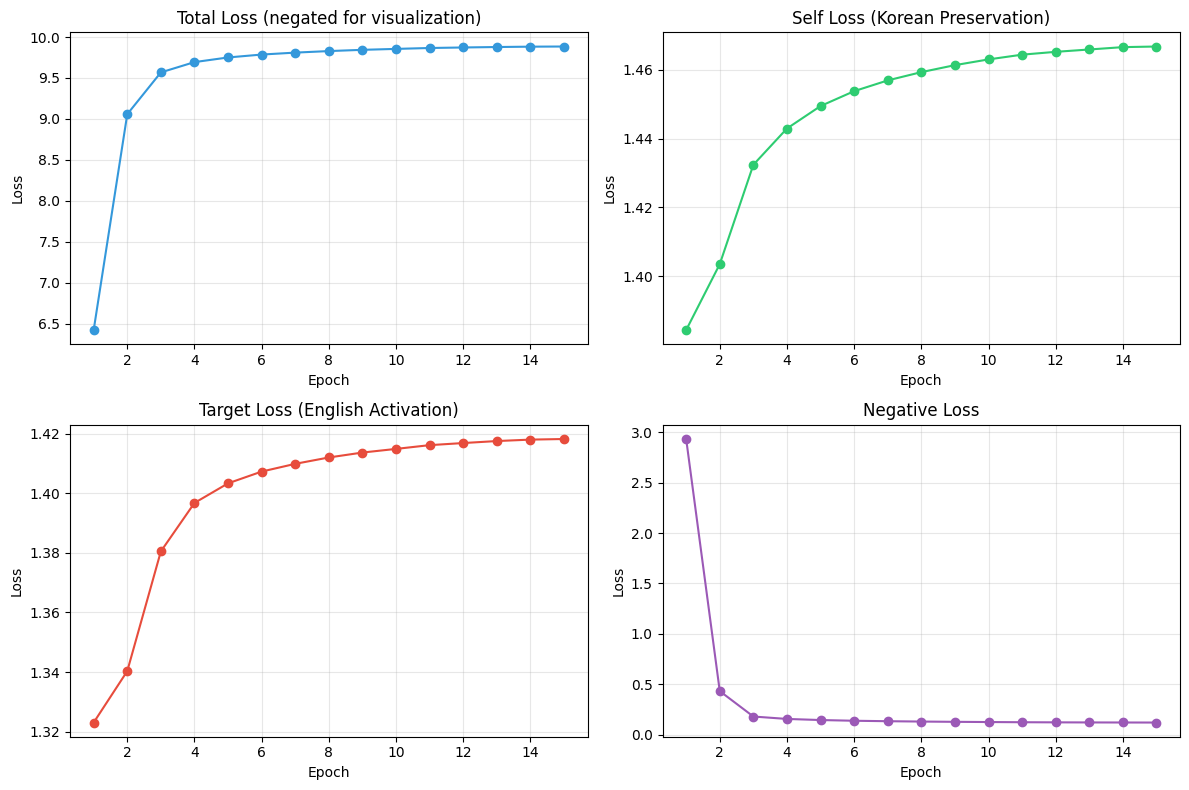

In [9]:
# Plot training curves
if history:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    epochs = range(1, len(history) + 1)

    # Total loss
    axes[0, 0].plot(epochs, [-h['total'] for h in history], '-o', color='#3498db')
    axes[0, 0].set_title('Total Loss (negated for visualization)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)

    # Self loss
    axes[0, 1].plot(epochs, [-h['self'] for h in history], '-o', color='#2ecc71')
    axes[0, 1].set_title('Self Loss (Korean Preservation)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True, alpha=0.3)

    # Target loss
    axes[1, 0].plot(epochs, [-h['target'] for h in history], '-o', color='#e74c3c')
    axes[1, 0].set_title('Target Loss (English Activation)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True, alpha=0.3)

    # Negative loss
    axes[1, 1].plot(epochs, [h['negative'] for h in history], '-o', color='#9b59b6')
    axes[1, 1].set_title('Negative Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 6. Detailed Analysis of Specific Terms

In [10]:
# Analyze specific terms in detail
print("=" * 80)
print("Detailed Analysis: Sample Terms")
print("=" * 80)

detail_terms = ["추천", "검색", "인공지능", "데이터베이스", "보안"]

for term in detail_terms:
    result = encode_term(term, top_k=15)
    print(f"\n{term}:")
    for i, (token, weight) in enumerate(result["tokens"][:10]):
        print(f"  {i+1:2}. {token:20} {weight:.4f}")

Detailed Analysis: Sample Terms

추천:
   1. 추천                   4.2605
   2. 코드                   4.2067
   3. 링크                   4.1749
   4. 웹사이트                 4.1714
   5. 검색                   4.1559
   6. 무료                   4.1521
   7. 오늘                   4.1466
   8. 그룹                   4.1466
   9. 온라인                  4.1459
  10. 서비스                  4.1443

검색:
   1. 검색                   4.2729
   2. 코드                   4.1760
   3. 설명                   4.1642
   4. 서비스                  4.1423
   5. 적                    4.1387
   6. 말씀                   4.1371
   7. 소셜그래프                4.1333
   8. 패                    4.1324
   9. 목적                   4.1321
  10. 라                    4.1317

인공지능:
   1. 인공지능                 4.2537
   2. 고민                   4.1491
   3. 모델                   4.1484
   4. 인간                   4.1352
   5. 영상                   4.1335
   6. 성격                   4.1297
   7. 어른                   4.1281
   8. 당신                   4.1252

## 7. Dataset Analysis

In [11]:
# Analyze v19 dataset
dataset_path = PROJECT_ROOT / "dataset" / "v19_high_quality" / "term_pairs.jsonl"

if dataset_path.exists():
    data = []
    sources = {}
    
    with open(dataset_path, "r", encoding="utf-8") as f:
        for line in f:
            item = json.loads(line.strip())
            data.append(item)
            source = item.get("source", "unknown")
            sources[source] = sources.get(source, 0) + 1
    
    print(f"Total pairs: {len(data):,}")
    print(f"\nData sources:")
    for source, count in sorted(sources.items(), key=lambda x: -x[1]):
        print(f"  {source}: {count:,} ({count/len(data)*100:.1f}%)")
    
    print(f"\nSample pairs:")
    for item in data[:10]:
        print(f"  {item['ko']} -> {item['en']} ({item.get('source', 'unknown')})")
else:
    print(f"Dataset not found: {dataset_path}")

Total pairs: 20,594

Data sources:
  muse: 20,455 (99.3%)
  wikidata: 119 (0.6%)
  it_terminology: 20 (0.1%)

Sample pairs:
  분류 -> category (muse)
  분류 -> categorization (muse)
  분류 -> categories (muse)
  분류 -> classification (muse)
  토론 -> discussions (muse)
  토론 -> discussion (muse)
  토론 -> debate (muse)
  토론 -> debates (muse)
  선수 -> players (muse)
  선수 -> player (muse)


## 8. Conclusion

### v19 Results Summary

v19 was trained with the following goals:

1. **Remove wikidata noise** from v18 dataset
2. **Focus on quality** over quantity (~18K vs 33K pairs)
3. **Use same hyperparameters** as successful v17 model

### Key Observations

- Korean preservation rate shows how well the model maintains the input Korean term
- English activation rate shows cross-lingual term expansion capability
- Combined score = Korean rate + English rate

### Next Steps

1. **Analyze data quality**: Investigate what makes certain translation pairs effective
2. **Loss function tuning**: Consider adjusting target loss weight for better English activation
3. **Data filtering**: Apply stricter quality filters to identify high-impact pairs